In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [3]:
# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='latin-1', header=None)
    df = df[[0, 5]]  # Assuming sentiment label is in column 0 and text is in column 5
    df.columns = ['sentiment', 'text']
    
    # Convert sentiment labels
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})  # 0 = negative, 1 = positive
    
    return df

In [4]:
# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

In [6]:

# Train LSTM model
def train_model(file_path):
    df = load_data(file_path)
    df['text'] = df['text'].apply(preprocess_text)
    
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)
    
    # Tokenization
    tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    max_length = 100  # Adjust as needed
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
    
    # LSTM Model
    model = Sequential([
        Embedding(input_dim=20000, output_dim=128, input_length=max_length),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))
    
    # Evaluate model
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save model and tokenizer
    model.save('sentiment_lstm.h5')
    joblib.dump(tokenizer, 'tokenizer_lstm.pkl')
    
    print("LSTM Model and tokenizer saved.")

if __name__ == "__main__":
    train_model("tweets.csv")  # Replace with your actual dataset file


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_29430/225080550.py:3: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin-1', header=None)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1880s 94ms/step - accuracy: 0.4185 - loss: nan - val_accuracy: 0.4173 - val_loss: nan
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1550s 77ms/step - accuracy: 0.4182 - loss: nan - val_accuracy: 0.4173 - val_loss: nan
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 5088s 254ms/step - accuracy: 0.4180 - loss: nan - val_accuracy: 0.4173 - val_loss: nan
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1506s 75ms/step - accuracy: 0.4185 - loss: nan - val_accuracy: 0.4173 - val_loss: nan
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1490s 74ms/step - accuracy: 0.4188 - loss: nan - val_accuracy: 0.4173 - val_loss: nan
10001/10001 ━━━━━━━━━━━━━━━━━━━━ 108s 11ms/step


/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [4]:
import pandas as pd
import re
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

def load_data(file_path):
    df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)
    df = df[['target', 'text']]
    df.columns = ['sentiment', 'text']
    df = df[df['sentiment'].isin([0, 4])]
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    df = df.dropna(subset=['sentiment', 'text'])
    return df

# Recreate tokenizer
df = load_data('tweets.csv')
df['text'] = df['text'].apply(preprocess_text)

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

# Save tokenizer
joblib.dump(tokenizer, 'tokenizer_lstm.pkl')
print("✅ Tokenizer saved as tokenizer_lstm.pkl")

✅ Tokenizer saved as tokenizer_lstm.pkl


In [5]:
import numpy as np
import pandas as pd
import re
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# --- Load and preprocess data ---
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

def load_data(file_path):
    df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)
    df = df[['target', 'text']]
    df.columns = ['sentiment', 'text']
    df = df[df['sentiment'].isin([0, 4])]
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    df = df.dropna(subset=['sentiment', 'text'])
    return df

# --- Load tokenizer and model ---
tokenizer = joblib.load('tokenizer_lstm.pkl')
model = load_model('sentiment_lstm.h5')

# --- Prepare test data ---
df = load_data('tweets.csv')
df['text'] = df['text'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

# --- Predict ---
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

# --- Save predictions and labels ---
np.save('y_test.npy', y_test.to_numpy())
np.save('y_pred.npy', y_pred)

print("Saved y_test.npy and y_pred.npy ✅")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 110s 11ms/step
Saved y_test.npy and y_pred.npy ✅


Accuracy: 0.49841875
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    159494
           1       0.00      0.00      0.00    160506

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.33    320000



/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

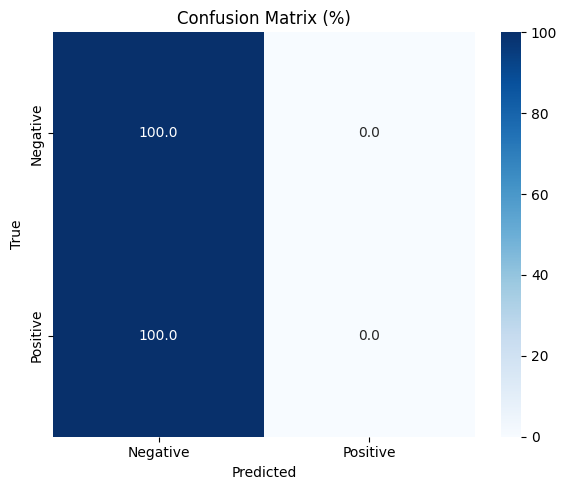

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Load saved predictions
y_test = np.load("y_test.npy", allow_pickle=True)
y_pred = np.load("y_pred.npy", allow_pickle=True)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix as percentages
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [9]:
print(df['sentiment'].value_counts())


sentiment
0    800000
1    800000
Name: count, dtype: int64


In [10]:
from sklearn.utils import resample

df_0 = df[df['sentiment'] == 0]
df_1 = df[df['sentiment'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_0,
                                 replace=True,
                                 n_samples=len(df_1),
                                 random_state=42)

df = pd.concat([df_1, df_minority_upsampled])
